### Data Loader

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import os
import re

In [26]:
# Setup path to data folder
data_path = Path("/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/")
image_path = data_path / "brightfield"

In [25]:
image_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well2_200locations'
mask_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/masks'

In [9]:
random.seed(42)
image_path_list = list(image_path.glob("*/*.tif")) # * means "any combination"
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

Random image path: /zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well2_200locations/Alexa488_Fibroblasts_well2_200locations_s088z02c2_ORG.tif
Image class: Alexa488_Fibroblasts_well2_200locations
Image height: 1024
Image width: 1024


In [45]:
class RandomFlipAndScale(object):
    def __call__(self, image, mask):
        # Randomly flip horizontally or vertically
        if torch.rand(1) > 0.5:
            image = torch.flip(image, dims=[2])  # Horizontal flip
            mask = torch.flip(mask, dims=[2])
        else:
            image = torch.flip(image, dims=[3])  # Vertical flip
            mask = torch.flip(mask, dims=[3])

        # Random scaling
        scale = torch.rand(1) * 0.2 + 0.9  # Scale factor between 0.9 and 1.1
        image = torch.nn.functional.interpolate(image, scale_factor=scale, mode='nearest')
        mask = torch.nn.functional.interpolate(mask, scale_factor=scale, mode='nearest')

        return image, mask

class RandomRotationAndContrast(object):
    def __call__(self, image, mask):
        # Random rotation
        angle = torch.randint(-60, 61, (1,))
        image = torch.rot90(image, angle, dims=[1, 2])
        mask = torch.rot90(mask, angle, dims=[1, 2])

        # Contrast adjustment
        contrast_factor = torch.rand(1) * 0.5 + 0.8  # Factor between 0.8 and 1.3
        image = image * contrast_factor

        return image, mask


class ShearAndNoise(object):
    def __call__(self, image, mask):
        # Shearing
        shear_factor = torch.rand(1) * 0.2 - 0.1  # Shear factor between -0.1 and 0.1
        theta = torch.tensor([[1, shear_factor], [0, 1]])
        grid = torch.nn.functional.affine_grid(theta.unsqueeze(0), image.size())
        image = torch.nn.functional.grid_sample(image.unsqueeze(0), grid, mode='bilinear', padding_mode='border').squeeze(0)
        mask = torch.nn.functional.grid_sample(mask.unsqueeze(0), grid, mode='nearest', padding_mode='border').squeeze(0)

        # Gaussian noise
        noise = torch.randn_like(image) * 0.05  # Adjust noise level as needed
        image = image + noise

        return image, mask

In [46]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
mask_transform = data_transform

In [47]:
transform1 = transforms.Compose(RandomFlipAndScale())
transform2 = transforms.Compose(RandomRotationAndContrast())
transform3 = transforms.Compose(ShearAndNoise())

In [55]:
class Well2ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        """
        Args:
            image_dir (str): Path to the directory containing images.
            mask_dir (str): Path to the directory containing masks.
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.sample_dict = self._get_sample_dict()

    def _get_sample_dict(self):
        """
        Organize images by sample ID into a dictionary where the keys are
        sample IDs and values are lists of image file paths corresponding to each sample.
        Each key (sample ID) maps to a list of 11 image paths and 1 mask path.
        """
        sample_dict = {}
        
        # Loop through images in the directory and group by sample ID
        for filename in os.listdir(self.image_dir):
            if filename.endswith("c2_ORG.tif"):  # Filter brightfield images only
                parts = filename.split('_')
                sample_id = parts[4][:4]  # Extract 's008' as the sample ID

                # Extract the z-index using regex
                match = re.search(r'z(\d{2})', filename)
                if match:
                    z_index = match.group(1)  # Get the two-digit z-index as a string (e.g., '01')
                    z_idx = int(z_index) - 1  # Convert to integer 0-10 for list indexing

                    if sample_id not in sample_dict:
                        sample_dict[sample_id] = {'images': [None] * 11, 'mask': None}

                    sample_dict[sample_id]['images'][z_idx] = os.path.join(self.image_dir, filename)
                    #print(sample_dict[sample_id]['images'][z_idx])
                    
                    # Determine the corresponding mask path based on sample_id and z06, c1 naming convention
                    if z_index == "06":  # Only one mask for focal point z06
                        mask_filename = f"{'_'.join(parts[:3])}_200locations_{parts[4][:7]}c1_ORG_mask.tiff"
                        #print(mask_filename)
                        mask_path = os.path.join(self.mask_dir, mask_filename)
                        if os.path.exists(mask_path):
                            sample_dict[sample_id]['mask'] = mask_path
                else:
                    print(f"Warning: Could not find z-index in filename {filename}")
        
        # Filter out samples with missing images or mask
        sample_dict = {k: v for k, v in sample_dict.items() if all(v['images']) and v['mask']}
        return sample_dict

    def __len__(self):
        return len(self.sample_dict)

    def __getitem__(self, idx):
        # Retrieve sample ID and paths
        sample_id = list(self.sample_dict.keys())[idx]
        image_paths = self.sample_dict[sample_id]['images']
        mask_path = self.sample_dict[sample_id]['mask']
        
        # Load the 11 images and apply transformations
        images = []
        for img_path in image_paths:
            img = Image.open(img_path).convert("L")  # Convert to grayscale if needed
            if self.transform:
                img = self.transform(img)
            images.append(img)
        
        # Stack images along the channel dimension to create (11, H, W)
        images = torch.stack(images, dim=0)
        images = images.squeeze(1)
        print(images.shape)

        # Load the mask and apply mask-specific transformations
        mask = Image.open(mask_path).convert("L")
        if self.mask_transform:
            mask = self.mask_transform(mask)
        print(mask.shape)
        
        images1, mask1 = transform1(images, mask)
        images2, mask2 = transform2(images, mask)
        images3, mask3 = transform3(images, mask)

        return images, mask, images1, mask1, images2, mask2, images3, mask3   # Return both the 11-channel image stack and the mask

In [56]:
images, mask, images1, mask1, images2, mask2, images3, mask3 = Well2ImageMaskDataset(image_dir=image_dir, mask_dir=mask_dir, transform=data_transform, mask_transform=mask_transform)

torch.Size([11, 128, 128])
torch.Size([1, 128, 128])


TypeError: __call__() takes 2 positional arguments but 3 were given

In [36]:
print("Number of images in the dataset:", len(dataset))

Number of images in the dataset: 196


TypeError: __call__() takes 2 positional arguments but 3 were given

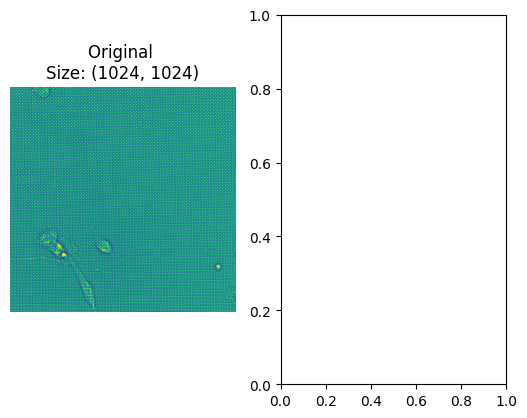

In [22]:
def plot_transformed_images(image_paths, transform1, transform2, transform3, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image1 = transform1(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image1) 
            ax[1].set_title(f"Transformed 2 \nSize: {transformed_image1.shape}")
            ax[1].axis("off")

            transformed_image2 = transform2(f).permute(1, 2, 0) 
            ax[2].imshow(transformed_image2) 
            ax[2].set_title(f"Transformed 2 \nSize: {transformed_image2.shape}")
            ax[2].axis("off")

            transformed_image3 = transform3(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image3) 
            ax[1].set_title(f"Transformed 2 \nSize: {transformed_image3.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform1=transform1, 
                        transform2=transform2,
                        transform3=transform3,
                        n=3)

In [ ]:
# Example usage
image, mask = ...  # Your original image and mask tensors
augmented_image, augmented_mask = transform(image, mask)